# Load the environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Common imports
import fitsio
import numpy as np
import os
import pandas as pd
import sys

In [3]:
# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', size=18)

In [4]:
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [5]:
# QuasarNET imports
from quasarnet.models import QuasarNET, custom_loss
from quasarnet.io import read_truth, read_data, objective, wave
from quasarnet.utils import process_preds, absorber_IGM

In [6]:
# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.compat.v1.reset_default_graph
    tf.random.set_seed(seed)
    np.random.seed(seed)

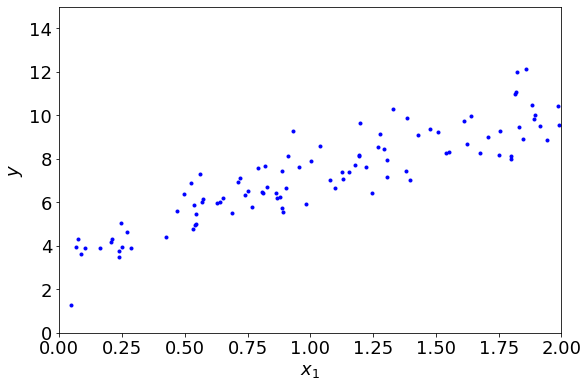

In [7]:
# Number of data points
m = 100

# y-intercept and slope of line
theta_0 = 4
theta_1 = 3

# Noise about true value
sigma_random = 1

# Random x values from 0 to 2, y values with noise around true line
X_lr = 2 * np.random.rand(m, 1)
y_lr = theta_0 + theta_1 * X_lr + np.random.normal(size=(m, 1),scale=sigma_random)

plt.figure(figsize=(9,6))
plt.plot(X_lr, y_lr, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.axis([0, 2, 0, 15]);

In [8]:
# Add the "bias" term to our x values
X_b = np.concatenate((np.ones((m,1)),X_lr),axis=1)

# Compute the analytic solution
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_lr)

print('Analytic solution:\ntheta_0={:1.3f}, theta_1={:1.3f}'.format(theta_best[0][0],theta_best[1][0]))
print('\nTrue values:\ntheta_0={:1.3f}, theta_1={:1.3f}'.format(theta_0,theta_1))

Analytic solution:
theta_0=3.720, theta_1=3.386

True values:
theta_0=4.000, theta_1=3.000


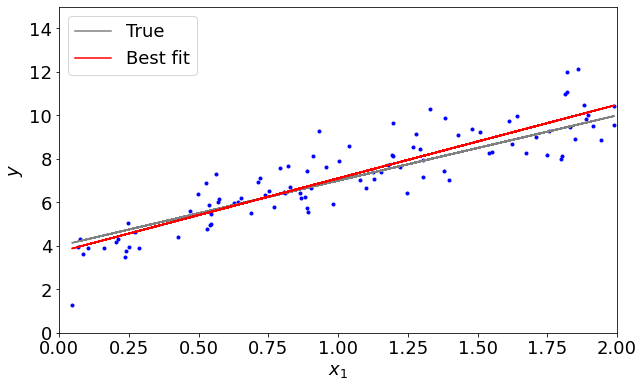

In [9]:
plt.figure(figsize=(10,6))
plt.plot(X_lr, y_lr, "b.")
plt.plot(X_lr, theta_0 + theta_1*X_lr, "grey", label='True')
plt.plot(X_lr, theta_best[0][0] + theta_best[1][0]*X_lr, "r", label='Best fit')
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.legend()
plt.axis([0, 2, 0, 15])
plt.show()

In [10]:
# Define our alpha, number of steps and starting value of theta.
alpha = 0.1
n_steps = 200
theta = np.array(([1.],[1.]))

# Set up a list to store the values of theta.
thetas = np.zeros((n_steps+1,2))
thetas[0,:] = theta.flatten()

# For each step:
for i in range(n_steps):
    
    # Calculate the gradient at this point.
    grad = (2/m)*X_b.T.dot(X_b.dot(theta)-y_lr)
    
    # Modify the current value of theta according to the gradient and the learning rate.
    theta += -alpha*grad
    
    # Add the new value of theta to our list
    thetas[i+1,:] = theta.flatten()
    
print('Gradient descent:\ntheta_0={:1.3f}, theta_1={:1.3f}'.format(theta[0][0],theta[1][0]))

Gradient descent:
theta_0=3.719, theta_1=3.387


In [11]:

print('Analytic solution:\ntheta_0={:1.3f}, theta_1={:1.3f}'.format(theta_best[0][0],theta_best[1][0]))
print('\nTrue values:\ntheta_0={:1.3f}, theta_1={:1.3f}'.format(theta_0,theta_1))

Analytic solution:
theta_0=3.720, theta_1=3.386

True values:
theta_0=4.000, theta_1=3.000


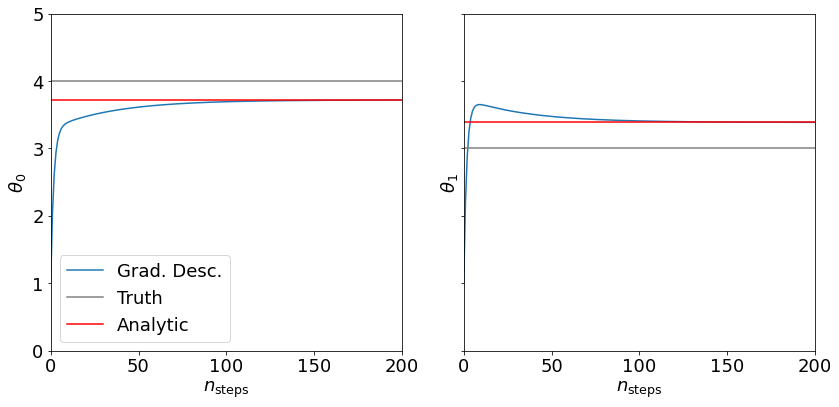

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)

axs[0].plot(range(n_steps+1),thetas[:,0],label='Grad. Desc.')
axs[0].axhline(y=theta_0,c='grey', label='Truth')
axs[0].axhline(y=theta_best[0][0],c='r', label='Analytic')
axs[0].set_xlabel(r'$n_{\mathrm{steps}}$')
axs[0].set_ylabel(r'$\theta_0$')

axs[1].plot(range(n_steps+1),thetas[:,1])
axs[1].axhline(y=theta_1,c='grey')
axs[1].axhline(y=theta_best[1][0],c='r')
axs[1].set_xlabel(r'$n_{\mathrm{steps}}$')
axs[1].set_ylabel(r'$\theta_1$')

axs[0].legend()
axs[0].set_xlim(0,n_steps)
axs[0].set_ylim(0,5)

plt.tight_layout()
plt.show()

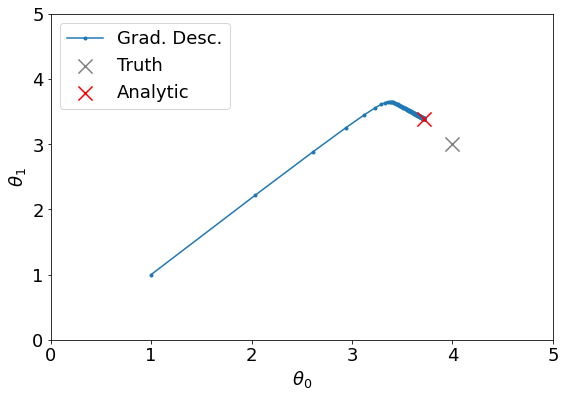

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(9,6))

ax.plot(thetas[:,0],thetas[:,1],".-",label='Grad. Desc.',zorder=-1)
ax.scatter(theta_0,theta_1,c='grey',marker='x',s=200, label='Truth')
ax.scatter(theta_best[0][0],theta_best[1][0],c='red',marker='x',s=200, label='Analytic')

ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.legend(loc=2)

In [14]:
import tensorflow as tf
reset_graph()

In [19]:
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

In [20]:
x

<tf.Variable 'x:0' shape=() dtype=int32, numpy=3>

In [21]:
y

<tf.Variable 'y:0' shape=() dtype=int32, numpy=4>

In [22]:
f

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [24]:
print(f'f={f}')

f=42


In [26]:
X_b = np.concatenate([np.ones_like(X_lr),X_lr],axis=1)
X_tf = tf.constant(X_b, dtype=tf.float32, name="X")
y_tf = tf.constant(y_lr, dtype=tf.float32, name="y")

In [27]:
alpha = 0.1
n_steps = 200
theta_init = np.array(([1.],[1.]))

In [28]:
theta_tf = tf.Variable(theta_init, dtype=tf.float32, name="theta")

In [29]:
for i in range(n_steps):

    # Calculate the gradient wrt theta
    with tf.GradientTape(persistent=True) as g:
        y_pred = tf.matmul(X_tf, theta_tf, name="predictions")
        error = y_pred - y_lr
        mse = tf.reduce_mean(tf.square(error), name="mse")
        
    grad = g.gradient(mse, theta_tf)
    
    # Update the value of theta
    theta_tf.assign(theta_tf - 0.1*grad)

In [30]:

print('TensorFlow:\ntheta_0={:1.3f}, theta_1={:1.3f}'.format(theta_tf[0][0],theta_tf[1][0]))

TensorFlow:
theta_0=3.719, theta_1=3.387


In [31]:
print('\nGradient descent:\ntheta_0={:1.3f}, theta_1={:1.3f}'.format(theta[0][0],theta[1][0]))
print('\nAnalytic solution:\ntheta_0={:1.3f}, theta_1={:1.3f}'.format(theta_best[0][0],theta_best[1][0]))
print('\nTrue values:\ntheta_0={:1.3f}, theta_1={:1.3f}'.format(theta_0,theta_1))


Gradient descent:
theta_0=3.719, theta_1=3.387

Analytic solution:
theta_0=3.720, theta_1=3.386

True values:
theta_0=4.000, theta_1=3.000


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [33]:
# Build the model.
model = Sequential([Dense(units=1, input_shape=(2,), use_bias=False, kernel_initializer=tf.constant_initializer(theta_init))])

# Set up the minimisation to carry out.
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
             )

# Run the minimisation.
history = model.fit(X_b, y_lr, batch_size=m, epochs=200, verbose=False)

In [34]:
theta_keras = model.get_layer(index=0).get_weights()[0]
print('TensorFlow:\ntheta_0={:1.3f}, theta_1={:1.3f}'.format(theta_keras[0][0],theta_keras[1][0]))

TensorFlow:
theta_0=3.719, theta_1=3.387


In [35]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


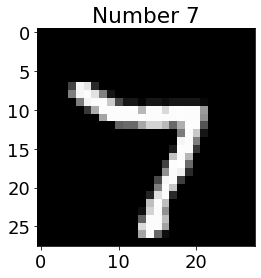

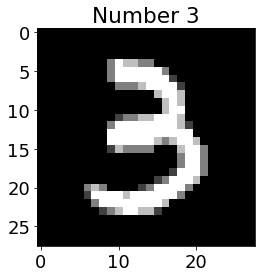

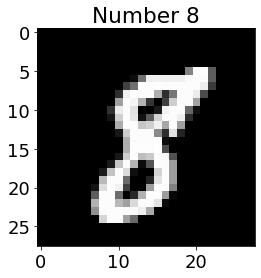

In [36]:

nshow = 3
toshow = np.random.choice(np.arange(x_train.shape[0]), size=nshow, replace=False)

for i in toshow:
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    ax.imshow(x_train[i],cmap='gray')
    ax.set_title('Number {}'.format(y_train[i]))

In [37]:
print('Min =',np.min(x_train),'\nMax =',np.max(x_train))

Min = 0 
Max = 255


In [38]:
x_train = x_train / 255.
x_test = x_test / 255.

In [39]:
n_units = 128
activation = 'relu'

In [40]:
layers = [
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(n_units, activation=activation),
]

In [41]:
layers += [
  tf.keras.layers.Dense(10, activation='softmax')
]

In [42]:
model = tf.keras.models.Sequential(layers)

In [43]:
learning_rate = 0.001
n_epochs = 6

In [44]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=['accuracy'],
)

In [45]:
model.fit(
    x_train,
    y_train,
    epochs=n_epochs,
)

Epoch 1/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2619 - accuracy: 0.9247
Epoch 2/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1137 - accuracy: 0.9664
Epoch 3/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0771 - accuracy: 0.9760
Epoch 4/6
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0570 - accuracy: 0.9827
Epoch 5/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0441 - accuracy: 0.9865
Epoch 6/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0353 - accuracy: 0.9891


In [46]:
y_pred = np.argmax(model.predict(x_test),axis=1)

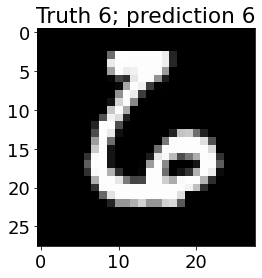

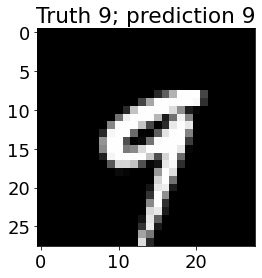

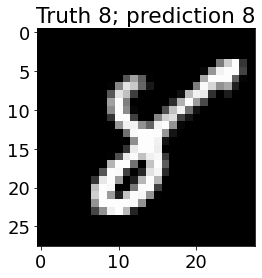

In [47]:
nshow = 3
toshow = np.random.choice(np.arange(x_test.shape[0]), size=nshow, replace=False)

for i in toshow:
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    ax.imshow(x_test[i],cmap='gray')
    
    ax.set_title('Truth {}; prediction {}'.format(y_test[i],y_pred[i]))

In [48]:
acc = (y_pred == y_test).sum()/len(y_test)
print('Accuracy = {:2.2%}'.format(acc))

Accuracy = 97.70%


# DESI

In [49]:
lines = ['LYA','CIV(1548)','CIII(1909)', 'MgII(2796)','Hbeta','Halpha']
lines_bal = ['CIV(1548)']

In [50]:
loss = [custom_loss]*(len(lines)+len(lines_bal))

In [51]:
nspec = 30000
truth_file=(['/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/truth_DR12Q.fits'])
truth = read_truth(truth_file)
tids_full,X_full,Y_full,z_full,bal_full = read_data(['/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_dr12.fits'], truth, nspec=nspec)

# Load the training data.
data_file = '/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_train_0.fits'
h = fitsio.FITS(data_file)
tids_train = h[1]['TARGETID'][:]
w = np.in1d(tids_full, tids_train)
X_train = X_full[w]
Y_train = Y_full[w]
z_train = z_full[w]
bal_train = bal_full[w]

# To get the validation data, remove the spectra in the training sample from the full sample
w = ~np.in1d(tids_full, tids_train)
tids_val = tids_full[w]
X_val = X_full[w]
Y_val = Y_full[w]
z_val = z_full[w]
bal_val = bal_full[w]

INFO: reading data from /global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_dr12.fits
INFO: removing 82 spectra missing in truth
INFO: found (29786,) spectra in file /global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_dr12.fits
INFO: removing 40 spectra with zero weights
INFO: removing 0 spectra with zero flux


In [72]:
tids_full,X_full,Y_full,z_full,bal_full

(array([87897905, 96906927, 96907939, ..., 64041484, 65543215, 66998726]),
 array([[ 2.54394281,  4.91944246,  7.00723035, ..., -1.43919068,
         -2.14751696, -1.20228153],
        [ 4.21498533, -7.74981107,  2.69009675, ..., -1.70719676,
         -3.35399962, -1.06193231],
        [-1.06286398,  9.20123416,  3.62385654, ..., -2.59693895,
         -3.34977909, -2.18795496],
        ...,
        [ 0.55770691,  1.89194261,  1.77392955, ..., -1.21611782,
         -1.72531606, -1.42132049],
        [ 7.45750934, -2.9862898 ,  4.24464032, ..., -0.8508344 ,
         -0.72928861, -0.93073517],
        [ 1.73247816, -5.47898489, -2.96747706, ..., -0.76814837,
          0.1458499 ,  0.72315643]]),
 array([[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([2.242, 2.259, 3.181, ..., 0.86 , 0.   , 0.341]),
 array([-1., -1., -1., ..., -1., -1., -1.]))

In [52]:

ntrain = 10000
nepochs = 5

In [53]:
model = QuasarNET((X_train.shape[1],1), nlines=len(lines)+len(lines_bal))

In [54]:
model.compile(optimizer=Adam(), loss=loss, metrics=[])

In [55]:
target, sample_weight = objective(z_train[:ntrain],Y_train[:ntrain],bal_train[:ntrain],lines=lines,lines_bal=lines_bal)
loss_history = model.fit(X_train[:ntrain,:,None], target, epochs=nepochs, batch_size=32, sample_weight=sample_weight)

Epoch 1/5
313/313 [==============================] - 9s 28ms/step - loss: 1.2622 - conc_box_0_loss: 0.1859 - conc_box_1_loss: 0.2113 - conc_box_2_loss: 0.2291 - conc_box_3_loss: 0.2109 - conc_box_4_loss: 0.1395 - conc_box_5_loss: 0.1079 - conc_box_6_loss: 0.1776
Epoch 2/5
313/313 [==============================] - 8s 27ms/step - loss: 0.2781 - conc_box_0_loss: 0.0400 - conc_box_1_loss: 0.0490 - conc_box_2_loss: 0.0590 - conc_box_3_loss: 0.0582 - conc_box_4_loss: 0.0241 - conc_box_5_loss: 0.0100 - conc_box_6_loss: 0.0379
Epoch 3/5
313/313 [==============================] - 8s 25ms/step - loss: 0.1578 - conc_box_0_loss: 0.0232 - conc_box_1_loss: 0.0287 - conc_box_2_loss: 0.0342 - conc_box_3_loss: 0.0324 - conc_box_4_loss: 0.0119 - conc_box_5_loss: 0.0041 - conc_box_6_loss: 0.0233
Epoch 4/5
313/313 [==============================] - 8s 27ms/step - loss: 0.0974 - conc_box_0_loss: 0.0163 - conc_box_1_loss: 0.0174 - conc_box_2_loss: 0.0217 - conc_box_3_loss: 0.0188 - conc_box_4_loss: 0.0063 

In [56]:
p = model.predict(X_val[:,:,None])
c_line, z_line, zbest, c_line_bal, z_line_bal = process_preds(p, lines, lines_bal)

INFO: nspec = 2412, nboxes=13


In [57]:
ndetect = 1
c_th = 0.5

In [58]:
def plot_spectrum(ival,X,c_line,z_line,zbest,Y,z,c_th=0.5,ndetect=1):
    
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.plot(wave, X[ival,:])
    
    isqso_truth = (Y[ival,:].argmax()==2) | (Y[ival,:].argmax()==3)
    isqso_qn = (c_line[:,ival].sum()>c_th)>=ndetect
    
    title = r'Is QSO? VI: {}, QN: {}'.format(isqso_truth,isqso_qn)
    title += '\n'
    title += r'$z_{{VI}}$={:1.3f}, $z_{{QN}}$='.format(z[ival])
    if isqso_qn:
        title += r'{:1.3f}'.format(zbest[ival])
    else:
        title += 'N/A'
    
    ax.set_title(title)
    m = X[ival,:].min()
    M = X[ival,:].max()
    ax.grid()
    ax.set_ylim(m-2,M+2)
    for il,l in enumerate(lines):
        lam = absorber_IGM[l]*(1+z_line[il,ival])
        w = abs(wave-lam)<100
        if w.sum()>0:
            m = X[ival,w].min()-1
            M = X[ival,w].max()+1
            ax.plot([lam,lam], [m,M],'r--', alpha=0.1+0.9*c_line[il,ival])
            ax.text(lam,M+0.5,'c$_{{{}}}={}$'.format(l,round(c_line[il,ival],3)),
                     horizontalalignment='center',alpha=0.1+0.9*c_line[il,ival])
    ax.set_xlabel(r'$\lambda_\mathrm{obs}~[\AA]$')
    ax.set_ylabel(r'renormalised flux')
    plt.show()
    
    return

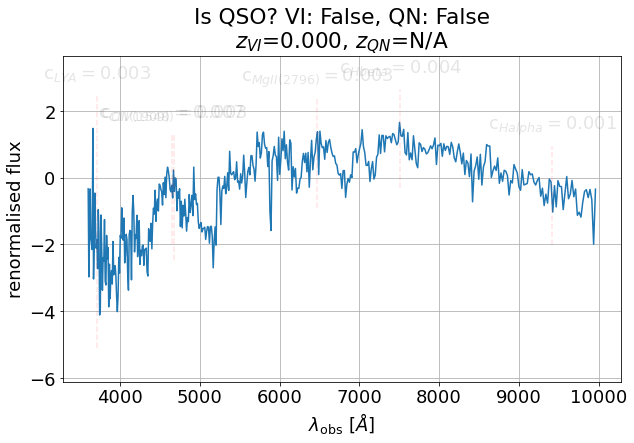

In [59]:
plot_spectrum(0,X_val,c_line,z_line,zbest,Y_val,z_val,c_th=c_th,ndetect=ndetect)

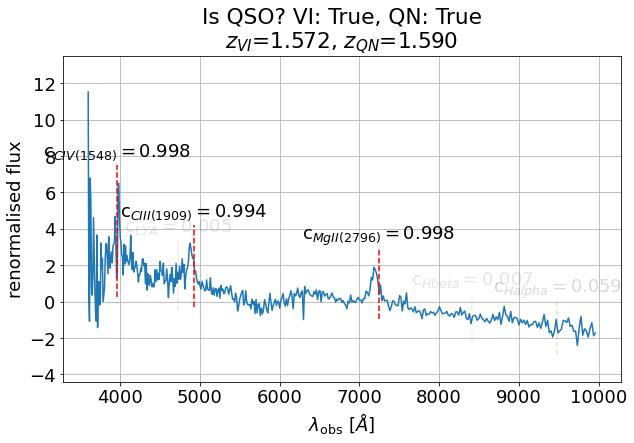

In [60]:
plot_spectrum(10,X_val,c_line,z_line,zbest,Y_val,z_val)

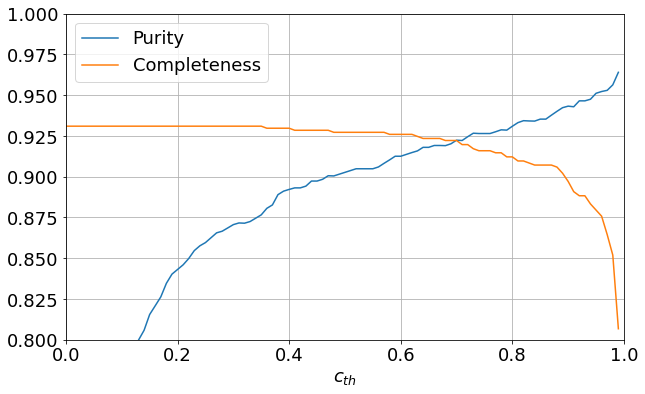

In [61]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

# Set up our arrays.
c_th = np.arange(0,1,0.01)
pur = c_th*0
com = c_th*0
dv_max = 6000./300000.

# Determine which objects are true QSOs, and which are "bad"
isqso_truth = (Y_val.argmax(axis=1)==2) | (Y_val.argmax(axis=1)==3)
is_bad = Y_val.argmax(axis=1)==4

# Determine which spectra QN accurately estimated the redshift for
zgood = (z_val>0) & (abs(zbest-z_val) < dv_max*(1+z_val))

# For each value of confidence threshold, compute purity and completeness.
for i,cth in enumerate(c_th):
    isqso_qn = (c_line>cth).sum(axis=0)>=ndetect
    ntrue_positives = (isqso_qn & zgood & ~is_bad).sum()
    pur[i] = ntrue_positives/(isqso_qn & (~is_bad)).sum()
    com[i] = (isqso_qn & zgood & isqso_truth).sum()/isqso_truth.sum()
    
# Plot them!
ax.plot(c_th, pur, label='Purity')
ax.plot(c_th, com, label='Completeness')
ax.set_xlim(0.0,1.0)
ax.set_ylim(0.8,1.0)
ax.set_xlabel(r'$c_{th}$')
ax.grid()
ax.legend()

# Real data

In [62]:
results = fitsio.FITS('/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/qn_on_68002.fits')

In [63]:
truth = read_truth(['/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/truth_68002.fits'])
truth = {k: truth[k] for k in truth.keys() if truth[k].z_conf_person==3}

In [64]:
# Open the data file and extract the targetids (tids) and spectra (X).
data_file = '/global/cfs/projectdirs/desi/users/jfarr/ML_TensorFlow_tutorial/data_andes_68002_20200315.fits'
h = fitsio.FITS(data_file)
tids = h[1]['TARGETID'][:]
X = h[0][:,:443]
X[:,434:443] = 0.
h.close()

# Include only spectra that we have true classifications/redshifts for, and are in our results.
w = np.array([((t in truth.keys()) & (t in results[1][:]['TARGETID'])) for t in tids])
tids = tids[w]
X = X[w,:]
z = np.array([truth[t].z_vi for t in tids])

In [66]:
classes = np.array([truth[t].class_person for t in tids])
z_conf = np.array([truth[t].z_conf_person for t in tids])
Y = np.zeros((X.shape[0],5))

## STAR
w = (classes==1) & (z_conf==3)
Y[w,0] = 1

## GALAXY
w = (classes==4) & (z_conf==3)
Y[w,1] = 1

## QSO_LZ
w = ((classes==3) | (classes==30)) & (z<2.1) & (z_conf==3)
Y[w,2] = 1

## QSO_HZ
w = ((classes==3) | (classes==30)) & (z>=2.1) & (z_conf==3)
Y[w,3] = 1

## BAD
w = z_conf != 3
Y[w,4] = 1

In [67]:
c_line = []
z_line = []
zbest = []
c_line_bal = []
z_line_bal = []
for tid in tids:
    w = np.in1d(results[1][:]['TARGETID'],tid)
    if w.sum()>0:
        c_line += [results[1][:][w]['C_LINES'][0]]
        z_line += [results[1][:][w]['Z_LINES'][0]]
        zbest += [results[1][:][w]['ZBEST'][0]]
        c_line_bal += [results[1][:][w]['C_LINES_BAL'][0]]
        z_line_bal += [results[1][:][w]['C_LINES_BAL'][0]]
c_line = np.array(c_line).T
z_line = np.array(z_line).T
zbest = np.array(zbest)
c_line_bal = np.array(c_line_bal).T
z_line_bal = np.array(z_line_bal).T

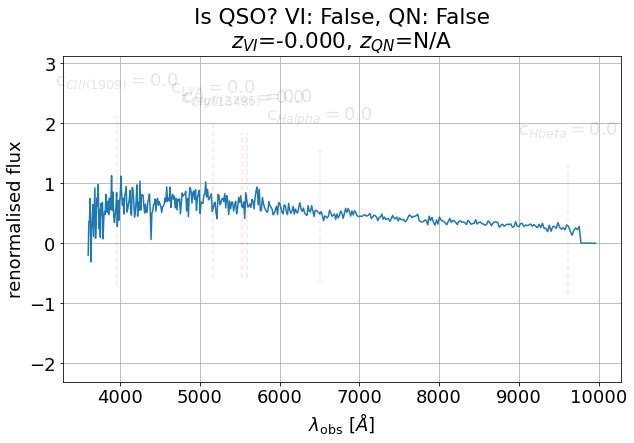

In [68]:
plot_spectrum(0,X,c_line,z_line,zbest,Y,z)

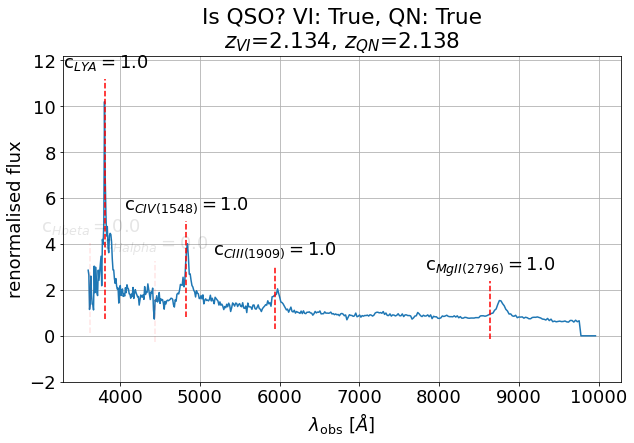

In [69]:
plot_spectrum(1,X,c_line,z_line,zbest,Y,z)

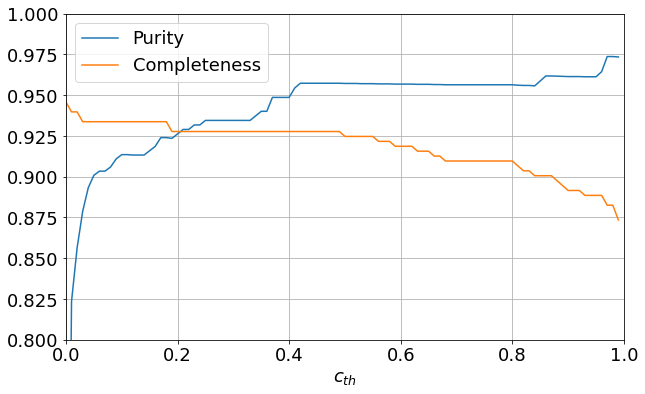

In [70]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

ndetect = 1

# Set up our arrays.
c_th = np.arange(0,1,0.01)
pur = c_th*0
com = c_th*0
dv_max = 6000./300000.

# Determine which objects are true QSOs, and which are "bad"
isqso_truth = (Y.argmax(axis=1)==2) | (Y.argmax(axis=1)==3)
is_bad = Y.argmax(axis=1)==4

# Determine which spectra QN accurately estimated the redshift for
zgood = (z>0) & (abs(zbest-z) < dv_max*(1+z))

# For each value of confidence threshold, compute purity and completeness.
for i,cth in enumerate(c_th):
    isqso_qn = (c_line>cth).sum(axis=0)>=ndetect
    ntrue_positives = (isqso_qn & zgood & ~is_bad).sum()
    pur[i] = ntrue_positives/(isqso_qn & (~is_bad)).sum()
    com[i] = (isqso_qn & zgood & isqso_truth).sum()/isqso_truth.sum()
    
# Plot them!
ax.plot(c_th, pur, label='Purity')
ax.plot(c_th, com, label='Completeness')
ax.set_xlim(0.0,1.0)
ax.set_ylim(0.8,1.0)
ax.set_xlabel(r'$c_{th}$')
ax.grid()
ax.legend()